In [1]:
from qiskit import Aer, execute, QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
# set number of assets (= number of qubits)
num_assets = 4
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

In [3]:
sigma

array([[ 2.54138859e-03,  7.34022167e-05,  1.28600531e-04,
        -9.98612132e-05],
       [ 7.34022167e-05,  2.58486713e-04,  5.30427595e-05,
         4.44816208e-05],
       [ 1.28600531e-04,  5.30427595e-05,  7.91504681e-04,
        -1.23887382e-04],
       [-9.98612132e-05,  4.44816208e-05, -1.23887382e-04,
         1.97892585e-04]])

In [4]:
mu

array([ 0.01528439, -0.00078095,  0.00051792,  0.00087001])

In [5]:
# plt.imshow(sigma, interpolation="nearest")
# plt.show()

#### Quadratic problem

In [6]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.001270694296030004*x_0^2 + 7.340221669347328e-05..., 4 variables, 1 constraints, 'Portfolio optimization'>

In [7]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

#### VQE

In [8]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 1.], value -0.0149

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.0149		0.8768
 [0 0 1 1]	-0.0010		0.0883
 [1 1 0 0]	-0.0130		0.0311
 [1 0 1 0]	-0.0140		0.0029
 [0 1 0 1]	0.0002		0.0005
 [0 1 1 0]	0.0008		0.0004
 [0 1 1 1]	1.0199		0.0000
 [1 1 1 0]	1.0069		0.0000
 [1 0 0 0]	1.0059		0.0000
 [0 1 0 0]	1.0208		0.0000
 [0 0 0 1]	1.0191		0.0000
 [0 0 0 0]	4.0795		0.0000
 [1 0 1 1]	1.0049		0.0000
 [1 1 0 1]	1.0060		0.0000
 [1 1 1 1]	4.0656		0.0000
 [0 0 1 0]	1.0197		0.0000


#### QAOA

In [9]:
algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 1.], value -0.0149

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.0149		0.1684
 [1 0 1 0]	-0.0140		0.1683
 [1 1 0 0]	-0.0130		0.1680
 [0 0 1 1]	-0.0010		0.1653
 [0 1 0 1]	0.0002		0.1651
 [0 1 1 0]	0.0008		0.1649
 [0 0 0 0]	4.0795		0.0000
 [1 1 1 1]	4.0656		0.0000
 [1 1 1 0]	1.0069		0.0000
 [1 0 1 1]	1.0049		0.0000
 [1 1 0 1]	1.0060		0.0000
 [0 1 0 0]	1.0208		0.0000
 [0 0 1 0]	1.0197		0.0000
 [0 0 0 1]	1.0191		0.0000
 [0 1 1 1]	1.0199		0.0000
 [1 0 0 0]	1.0059		0.0000


#### Decomposition

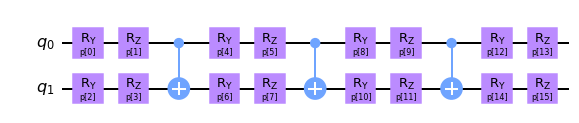

In [10]:
qc = QuantumCircuit(2)

r = 4
theta = ParameterVector('p', 2*4*r)

t = 0
for i in range(r):   
    qc.ry(theta[t], 0)
    qc.rz(theta[t+1],0)
    qc.ry(theta[t+2], 1)
    qc.rz(theta[t+3], 1)
    if i < r-1: qc.cnot(0,1)
    t += 4
qc.draw(output="mpl")

In [11]:
qc = QuantumCircuit(4)

r = 4
theta = ParameterVector('p', 2*4*r)

t = 0
for i in range(r):   
    qc.ry(theta[t], 0)
    qc.rz(theta[t+1],0)
    qc.ry(theta[t+2], 1)
    qc.rz(theta[t+3], 1)
    if i < r-1: qc.cnot(0,1)
    t += 4

t = int(len(theta)/2)
for i in range(r):   
    qc.ry(theta[t], 2)
    qc.rz(theta[t+1],2)
    qc.ry(theta[t+2], 3)
    qc.rz(theta[t+3], 3)
    if i < r-1: qc.cnot(2,3)
    t += 4

# qc.draw(output="mpl")

In [12]:
algorithm_globals.random_seed = 1234
# backend = Aer.get_backend("statevector_simulator")

backend = Aer.get_backend('aer_simulator')
backend.shots = 1024

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
# ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(qc, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print(result.x)

[1. 0. 0. 1.]
